
# Projet 6 - Classification Automatique des Biens de Consommation

## Partie 3 de 3

# 1. Introduction

## 1.1 Le Contexte

L’entreprise "Place de marché", qui souhaite lancer une marketplace e-commerce, voudrait mettre en place un moteur de classification: la catégorie d'un article est attribuée automatiquement après le téléchargement d'une photo de l'article. L'entreprise attend que un tel moteur de classification a les bénéfices suivantes :
* augmenter la fiabilité de la classification
* une facilité d'utilisation 
    * pour les vendeurs (qui entrent pour l'instant entrent cette info manuellement)
    * pour les achêteurs pour leur recherche de produit

## 1.2 Objectif

* **Etudier la faisabilité d'un moteur de classification** 
    * analyse de jeu de données
    * prétraitement des déscriptions (texte) et des images
    * réduction de dimension
    * clustering

## 1.3 Résumé de ce Notebook

Dans ce notebook, on traite les images. On ustilise SIFT pour identifier des keypoints et créer des descripteurs. Ces descripteurs sont regroupés dans des clusters qui vont servir de virtual tokens / words / topics. 

Conclusions:
* Il n'y a pas des clusters évidents.
* Une classification avec les méthodes SIFT a l'air d'être difficile.
* Tant qu'on réussir à faire une classification des images avec une accuray plus que 0.5, on peut combiner la classification d'images avec celui de textes. (Méthode ensembliste)
* Chercher d'autre pistes: e.g. un algorithme de type CNN Transfer Learning

# 2. Les Imports

## 2.1 Les Bibliothèques et Styles

In [1]:
import re, os, random

from time import time

from math import ceil
# a convenient module for punctuation signs
import string

from itertools import zip_longest

#data modules
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import chisquare
from scipy.sparse import csr_matrix

#graphic modules
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib.colors import ListedColormap


#import matplotlib.dates as dates
import seaborn as sns

In [2]:
import cv2

In [3]:
from collections import defaultdict
from collections import Counter

In [4]:
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, MinMaxScaler

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest, SelectFpr, chi2

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding, TSNE, SpectralEmbedding
from sklearn.random_projection import SparseRandomProjection

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch, DBSCAN, MiniBatchKMeans, OPTICS, SpectralClustering
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics

In [5]:
%matplotlib inline

## 2.2 Les Fonctions

In [6]:
def create_sift_keypoints(photo_list, path=os.getcwd(), use_canny=False, **kwags):
    '''A function that returns a list of descriptors of an image using SIFT.\
    The image filenames are listed in phots_list and the directory is given by path.'''
    sift_keypoints = []
    sift = cv2.xfeatures2d.SIFT_create(**kwags,)

    for image_num, image_file in enumerate(photo_list) :
        if image_num%100 == 0 : print(f"{str(image_num).zfill(4)} Images have been treated.")
        image = cv2.imread(path+image_file, 0) # 0 = convert in gray (1 = color, -1 = unchanged)
        #image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        if use_canny :
            image=cv2.Canny(image, 60, 60)
        res = cv2.equalizeHist(image)   # equalize image histogram
        kp, des = sift.detectAndCompute(res, None)
        sift_keypoints.append(des)
    print(f"{str(image_num+1).zfill(4)} Images have been treated in total. --- END.")
    return sift_keypoints

In [7]:
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print(f"There is an issue with image {image_num}. The histogram contains no elements.")
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

In [8]:
def create_histogram_vectors(sift_keypoints, kmeans) :
    # Creation of a matrix of histograms
    hist_vectors=[]
    for image_num, image_desc in enumerate(sift_keypoints) :
        if image_num%100 == 0 : print(f"{str(image_num).zfill(4)} Images have been treated.")
        hist = build_histogram(kmeans, image_desc, image_num) #calculates the histogram
        hist_vectors.append(hist) #histogram is the feature vector
    print(f"{str(image_num+1).zfill(4)} Images have been treated in total. --- END.")
    return hist_vectors

In [134]:
def plot_embedding(X, y, title, ax):
    X = MinMaxScaler().fit_transform(X)
    scatter = ax.scatter(X[:,0], X[:,1], c=y, cmap=ListedColormap(sns.color_palette('tab10'), N=len(set(y))), s=6)
    ax.set_title(title)
    ax.axis("off")
    return scatter

## 2.3 Les Données

In [9]:
PATH = os.getcwd() + '\\Data\\'
filename = 'Text_Tokenized.csv'
text_df = pd.read_csv(PATH + filename)

In [10]:
text_df

,Unnamed: 0,image_id,product_name,category_level1,category_level2,document_nltk,document_spacy,document_nltk_2,document_spacy_2,document_nltk_3,document_spacy_3
0,0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,Curtains & Accessories,key features elegance polyester multicolor abs...,key features elegance polyester multicolor abs...,key features elegance polyester multicolor abs...,key features elegance polyester multicolor abs...,key elegance polyester multicolor abstract eye...,key elegance polyester multicolor abstract eye...
1,1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Baby Care,Baby Bath & Skin,specifications sathiyas cotton bath towel 3 ba...,specification sathiyas cotton bath towel 3 bat...,specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,sathiyas cotton bath towel bath towel red yell...,sathiyas cotton bath towel bath towel red yell...
2,2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Baby Care,Baby Bath & Skin,key features eurospa cotton terry face towel s...,key features eurospa cotton terry face towel s...,key features eurospa cotton terry face towel s...,key features eurospa cotton terry face towel s...,key eurospa cotton terry face towel set small ...,key eurospa cotton terry face towel set small ...
3,3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,Bed Linen,key features santosh royal fashion cotton prin...,key features santosh royal fashion cotton prin...,key features santosh royal fashion cotton prin...,key features santosh royal fashion cotton prin...,key santosh royal fashion cotton printed king ...,key santosh royal fashion cotton printed king ...
4,4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,Bed Linen,key features jaipur print cotton floral king s...,key features jaipur print cotton floral king s...,key features jaipur print cotton floral king s...,key features jaipur print cotton floral king s...,key jaipur print cotton floral king double bed...,key jaipur print cotton floral king double bed...
...,...,...,...,...,...,...,...,...,...,...,...
1045,1045,958f54f4c46b53c8a0a9b8167d9140bc,Oren Empower Extra Large Self Adhesive Sticker,Baby Care,Baby & Kids Gifts,oren empower extra large self adhesive sticker...,oren empower extra large self adhesive sticker...,oren empower extra large self adhesive sticker...,oren empower extra large self adhesive sticker...,oren empower extra large self adhesive sticker...,oren empower extra large self adhesive sticker...
1046,1046,fd6cbcc22efb6b761bd564c28928483c,Wallmantra Large Vinyl Sticker Sticker,Baby Care,Baby & Kids Gifts,wallmantra large vinyl sticker sticker pack 1 ...,wallmantra large vinyl sticker sticker pack 1 ...,wallmantra large vinyl sticker sticker pack pr...,wallmantra large vinyl sticker sticker pack pr...,wallmantra large vinyl sticker sticker bring h...,wallmantra large vinyl sticker sticker bring h...
1047,1047,5912e037d12774bb73a2048f35a00009,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Baby Care,Baby & Kids Gifts,buy uberlyfe extra large pigmented polyvinyl f...,buy uberlyfe extra large pigment polyvinyl fil...,buy uberlyfe extra large pigmented polyvinyl f...,buy uberlyfe extra large pigment polyvinyl fil...,uberlyfe extra large pigmented polyvinyl films...,uberlyfe extra large pigment polyvinyl films i...
1048,1048,c3edc504d1b4f0ba6224fa53a43a7ad6,Wallmantra Medium Vinyl Sticker Sticker,Baby Care,Baby & Kids Gifts,buy wallmantra medium vinyl sticker sticker rs...,buy wallmantra medium vinyl sticker sticker rs...,buy wallmantra medium vinyl sticker sticker rs...,buy wallmantra medium vinyl sticker sticker rs...,wallmantra medium vinyl sticker sticker wallma...,wallmantra medium vinyl sticker sticker wallma...


In [11]:
text_df = text_df.drop(columns = ['Unnamed: 0'])

# 3. Le Target

In [12]:
le = LabelEncoder()
cat = 'category_level1'
y = le.fit_transform(text_df[cat])

In [13]:
X_img_descriptors = {}
X_img_featutres = {}
X_datas = {}
X_projections = {}

In [14]:
X_labels = {}

# 4. Les Descripteurs SIFT

## 4.0 Un example

In [15]:
photo_list = [i +'.jpg' for i in text_df['image_id']]

d8ef80a8ba345dedc9f944cf21201988.jpg


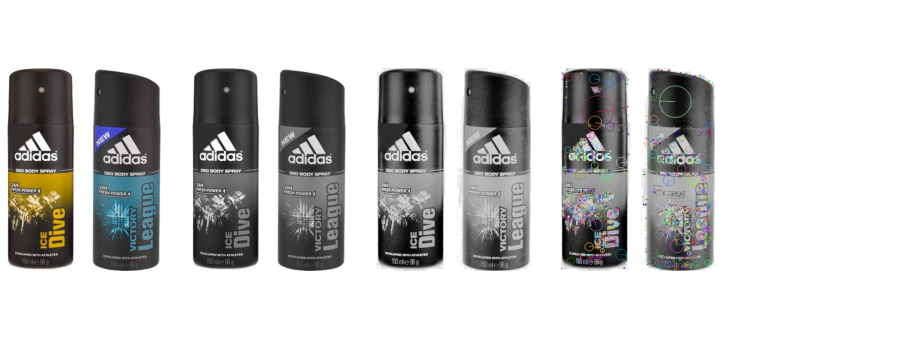

Descripteurs :  (1216, 128)

[[ 72.   7.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...  18.   3.   0.]
 [  0.   0.   4. ...   0.   0.   0.]
 ...
 [  0.   0.   1. ... 102.  38.  11.]
 [166.  12.   0. ...   0.   0.   0.]
 [ 89.   0.   0. ...   0.   0.   0.]]


In [16]:
#randomly choose an image and look at its SIFT descripteurs
sift = cv2.xfeatures2d.SIFT_create()
name = random.sample(photo_list, k=1)[0]
print(name)
#name = '968a2b3be84193e3f755c2fe71033a2c.jpg'
name = '4e03d4e81e6a876f512536f6a57c053e.jpg'
name = 'c6cd71c28144224b080cdec222bc4833.jpg'
#name = '60a7313ea1e0ee8d845a0a6dec6117cc.jpg'
#name = 'b5b47b2ecf5cf5760051b0a980ed7a3f.jpg'

fig, axs = plt.subplots(1,5, figsize=(16,6))
image = cv2.imread(PATH + "Flipkart\\Images\\" + name, 1) # convert in gray
axs[0].imshow(image)
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
axs[1].imshow(image, cmap='gray')
#image = cv2.Canny(image, 80, 80)
#axs[i+1].imshow(image, cmap='gray')
image = cv2.equalizeHist(image)   # equalize image histogram
axs[2].imshow(image, cmap='gray')
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
axs[3].imshow(img)

for i in range(5):
    axs[i].axis('off')
plt.show()  

print("Descripteurs : ", des.shape)
print()
print(des)

## 4.1 Version1 - 1000 Features

In [17]:
data_ver = "Version1"
nfeatures = 1000

In [18]:
# identification of key points and associated descriptors
temps1=time()

sift_keypoints_by_img = np.asarray(create_sift_keypoints(photo_list, PATH+"Flipkart\\Images\\", nfeatures=nfeatures))
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Number of SIFT descriptors : ", sift_keypoints_all.shape)

duration1=time()-temps1
print("Run time for the SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0000 Images have been treated.
0100 Images have been treated.
0200 Images have been treated.
0300 Images have been treated.
0400 Images have been treated.
0500 Images have been treated.
0600 Images have been treated.
0700 Images have been treated.
0800 Images have been treated.
0900 Images have been treated.
1000 Images have been treated.
1050 Images have been treated in total. --- END.


<ipython-input-18-1d5c103e69c5>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(create_sift_keypoints(photo_list, PATH+"Flipkart\\Images\\", nfeatures=nfeatures))



Number of SIFT descriptors :  (989655, 128)
Run time for the SIFT descriptor :           374.96 secondes


In [19]:
#from sklearn import cluster, metrics

# Determination number of clusters
temps1=time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Maximum Number of Clusters : ", k)
print(f"Creation of {k} SIFT-Descriptor Clusters ...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time()-temps1
print("Run time for MiniBatchKMeans : ", "%15.2f" % duration1, "seconds")

Maximum Number of Clusters :  995
Creation of 995 SIFT-Descriptor Clusters ...
Run time for MiniBatchKMeans :            21.81 seconds


In [20]:
# Creation of histograms (features)
temps1=time()

im_features = np.asarray(create_histogram_vectors(sift_keypoints_by_img, kmeans))

duration1=time()-temps1
print("Total time to create Histograms : ", "%15.2f" % duration1, "secondes")

0000 Images have been treated.
0100 Images have been treated.
0200 Images have been treated.
0300 Images have been treated.
0400 Images have been treated.
0500 Images have been treated.
0600 Images have been treated.
0700 Images have been treated.
0800 Images have been treated.
0900 Images have been treated.
1000 Images have been treated.
1050 Images have been treated in total. --- END.
Total time to create Histograms :            24.12 secondes


(array([147., 561., 186.,  52.,  24.,  13.,   8.,   0.,   2.,   2.]),
 array([0.35144931, 0.73620992, 1.12097052, 1.50573113, 1.89049174,
        2.27525235, 2.66001296, 3.04477357, 3.42953418, 3.81429479,
        4.19905539]),
 <BarContainer object of 10 artists>)

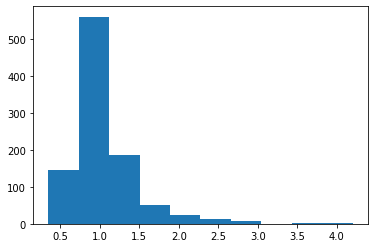

In [21]:
plt.hist(pd.DataFrame(im_features).sum())

In [22]:
pd.DataFrame(im_features).join(text_df[cat]).groupby(by=cat).sum()

,0,1,2,3,4,5,6,7,8,9,...,985,986,987,988,989,990,991,992,993,994
category_level1,,,,,,,,,,,,,,,,,,,,,
Baby Care,0.057615,0.208149,0.090058,0.460922,0.510440,0.788583,0.156969,0.166396,0.123552,0.173971,...,0.125634,0.108402,0.257211,0.113435,0.113174,0.080642,0.129951,0.126168,0.135156,0.086030
Beauty and Personal Care,0.123775,0.157606,0.138947,0.238168,0.388209,0.017996,0.084907,0.086767,0.326773,0.132377,...,0.133387,0.219529,0.174201,0.137666,0.110987,0.152071,0.154004,0.102980,0.152595,0.101375
Computers,0.072931,0.245645,0.068938,0.333324,0.666641,0.109700,0.219905,0.086184,0.193506,0.055865,...,0.215635,0.104909,0.227534,0.209312,0.121722,0.061411,0.072925,0.153289,0.125161,0.133915
Home Decor & Festive Needs,0.090035,0.134640,0.093104,0.301164,0.129597,0.146007,0.079204,0.138183,0.071023,0.386774,...,0.174366,0.079322,0.142137,0.067555,0.167281,0.134188,0.083963,0.135831,0.213059,0.105521
Home Furnishing,0.073985,0.103735,0.106973,0.281198,0.390193,0.313898,0.138680,0.167824,0.089985,0.411778,...,0.081997,0.093973,0.208330,0.073979,0.110359,0.112562,0.146338,0.086364,0.144182,0.047360
Kitchen & Dining,0.055150,0.281369,0.071664,0.162292,0.422732,0.068507,0.223852,0.083948,0.085338,0.111219,...,0.216288,0.101481,0.156885,0.272645,0.138507,0.106529,0.129677,0.148655,0.220024,0.115788
Watches,0.324101,0.185198,0.079497,0.299068,0.448092,0.082255,0.187615,0.082471,0.328128,0.043883,...,0.074179,0.106966,0.202044,0.202526,0.078739,0.074228,0.077390,0.123176,0.069055,0.095477


In [23]:
chi2_values = chisquare(pd.DataFrame(im_features).join(text_df[cat]).groupby(by=cat).sum())
chistats_df = pd.DataFrame(np.array([chi2_values.statistic, chi2_values.pvalue]).T, 
                           columns=['Chi2', 'pValue'])
chistats_df.sort_values(by='pValue', ascending=True).iloc[:60,:]

,Chi2,pValue
602,2.834709,0.829288
751,2.749603,0.839554
885,2.333110,0.886658
5,1.982486,0.921302
162,1.895655,0.929041
898,1.727291,0.942995
533,1.611750,0.951729
327,1.536422,0.957039
364,1.530445,0.957447
513,1.391545,0.966371


In [24]:
print("Dimensions of the dataset before reduction with a PCA : ", im_features.shape)
pca = PCA(n_components=0.99)
X_pca= pca.fit_transform(im_features)
print("Dimensions of the dataset after reduction with a PCA : ", X_pca.shape)

Dimensions of the dataset before reduction with a PCA :  (1050, 995)
Dimensions of the dataset after reduction with a PCA :  (1050, 579)


In [25]:
X_img_descriptors[data_ver] = sift_keypoints_by_img
X_img_featutres[data_ver] = im_features

In [26]:
X_datas[data_ver] = X_pca

### 4.1.1 Les Projections en 2D

In [27]:
data_ver = "Version1"
X_projections[data_ver] = {}

#### PCA

In [124]:
data_ver = "Version1"
proj_name = "PCA"
proj = PCA(n_components=2)

In [125]:
X_tmp = proj.fit_transform(X_datas[data_ver])
X_projections[data_ver][proj_name] = {"X_proj" : X_tmp}

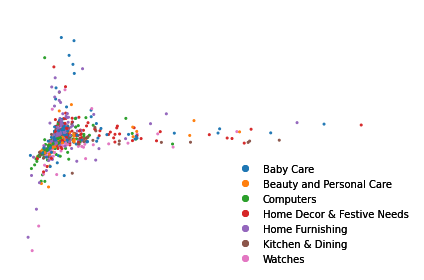

In [133]:
fig, ax = plt.subplots(figsize=(6,4))
X_tmp = X_projections[data_ver][proj_name]["X_proj"]
output = ax.scatter(X_tmp[:,0], X_tmp[:,1], c=y, 
           cmap=ListedColormap(sns.color_palette('tab10'), N=len(set(y))), s=4)
legend1 = ax.legend(output.legend_elements()[0], le.inverse_transform([i for i in range(7)]),
                    loc="lower right", frameon=False)
ax.add_artist(legend1)
ax.axis('off')
plt.xlim(-0.01, 0.05)
plt.ylim(-0.15, 0.15)
plt.tight_layout()

#### TSNE1

In [146]:
data_ver = "Version1"
proj_name = "TSNE1"
proj = TSNE(n_components=2, perplexity=15, n_iter=2000, init='pca', random_state=6)

In [147]:
X_tmp = proj.fit_transform(X_datas[data_ver])
X_projections[data_ver][proj_name] = {"X_proj" : X_tmp}

c:\users\bookj\environments\jupenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\users\bookj\environments\jupenv\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


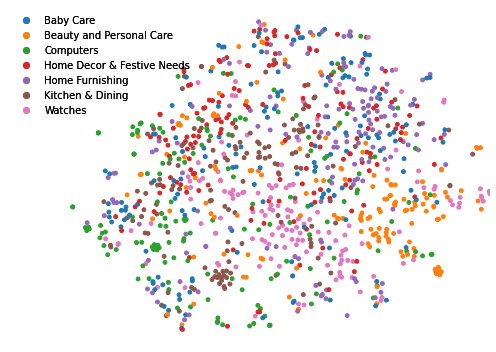

In [158]:
fig, ax = plt.subplots(figsize=(7,5))
X_tmp = X_projections[data_ver][proj_name]["X_proj"]
output = ax.scatter(X_tmp[:,0], X_tmp[:,1], c=y, 
                    cmap=ListedColormap(sns.color_palette('tab10'), N=len(set(y))), s=15)
legend1 = ax.legend(output.legend_elements()[0], le.inverse_transform([i for i in range(7)]),
                    loc="upper left", frameon=False)
ax.add_artist(legend1)
ax.axis('off')
plt.xlim(-80, 60)
#plt.ylim(-0.15, 0.15)
plt.tight_layout()

#### Manifold apprentissage

Pris du website de SKlearn : 
https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py

In [144]:
n_neighbors = 15

embeddings = {
    "Random projection embedding": SparseRandomProjection(
        n_components=2, random_state=42
    ),
    "Truncated SVD embedding": TruncatedSVD(n_components=2),
    "Linear Discriminant Analysis embedding": LinearDiscriminantAnalysis(
        n_components=2
    ),
    "Isomap embedding": Isomap(n_neighbors=n_neighbors, n_components=2),
    "Standard LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="standard"
    ),
    "Modified LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="modified"
    ),
    "Hessian LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="hessian", eigen_solver="dense"
    ),
    "LTSA LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="ltsa", eigen_solver="dense" 
    ),
    "MDS embedding": MDS(n_components=2, n_init=1, max_iter=120, n_jobs=2),
    "Random Trees embedding": make_pipeline(
        RandomTreesEmbedding(n_estimators=200, max_depth=5, random_state=0),
        TruncatedSVD(n_components=2),
    ),
    "Spectral embedding": SpectralEmbedding(
        n_components=2, random_state=0, eigen_solver="arpack"
    ),
    "t-SNE embedding": TSNE(
        n_components=2,
        init="pca",
        learning_rate="auto",
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    ),
    "NCA embedding": NeighborhoodComponentsAnalysis(
        n_components=2, init="pca", random_state=0
    ),
}

In [145]:
data_var = "Version1"
projections_embd, timing = {}, {}
for name, transformer_embd in embeddings.items():
    if name.startswith("Linear Discriminant Analysis"):
        data = X_datas[data_ver].copy()
        data.flat[:: X_datas[data_ver].shape[1] + 1] += 0.01  # Make X invertible
    else:
        data = X_datas[data_ver]

    print(f"Computing {name}...")
    start_time = time()
    projections_embd[name] = transformer_embd.fit_transform(data, y)
    timing[name] = time() - start_time

Computing Random projection embedding...
Computing Truncated SVD embedding...
Computing Linear Discriminant Analysis embedding...
Computing Isomap embedding...
Computing Standard LLE embedding...
Computing Modified LLE embedding...
Computing Hessian LLE embedding...
Computing LTSA LLE embedding...
Computing MDS embedding...
Computing Random Trees embedding...
Computing Spectral embedding...
Computing t-SNE embedding...


c:\users\bookj\environments\jupenv\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Computing NCA embedding...


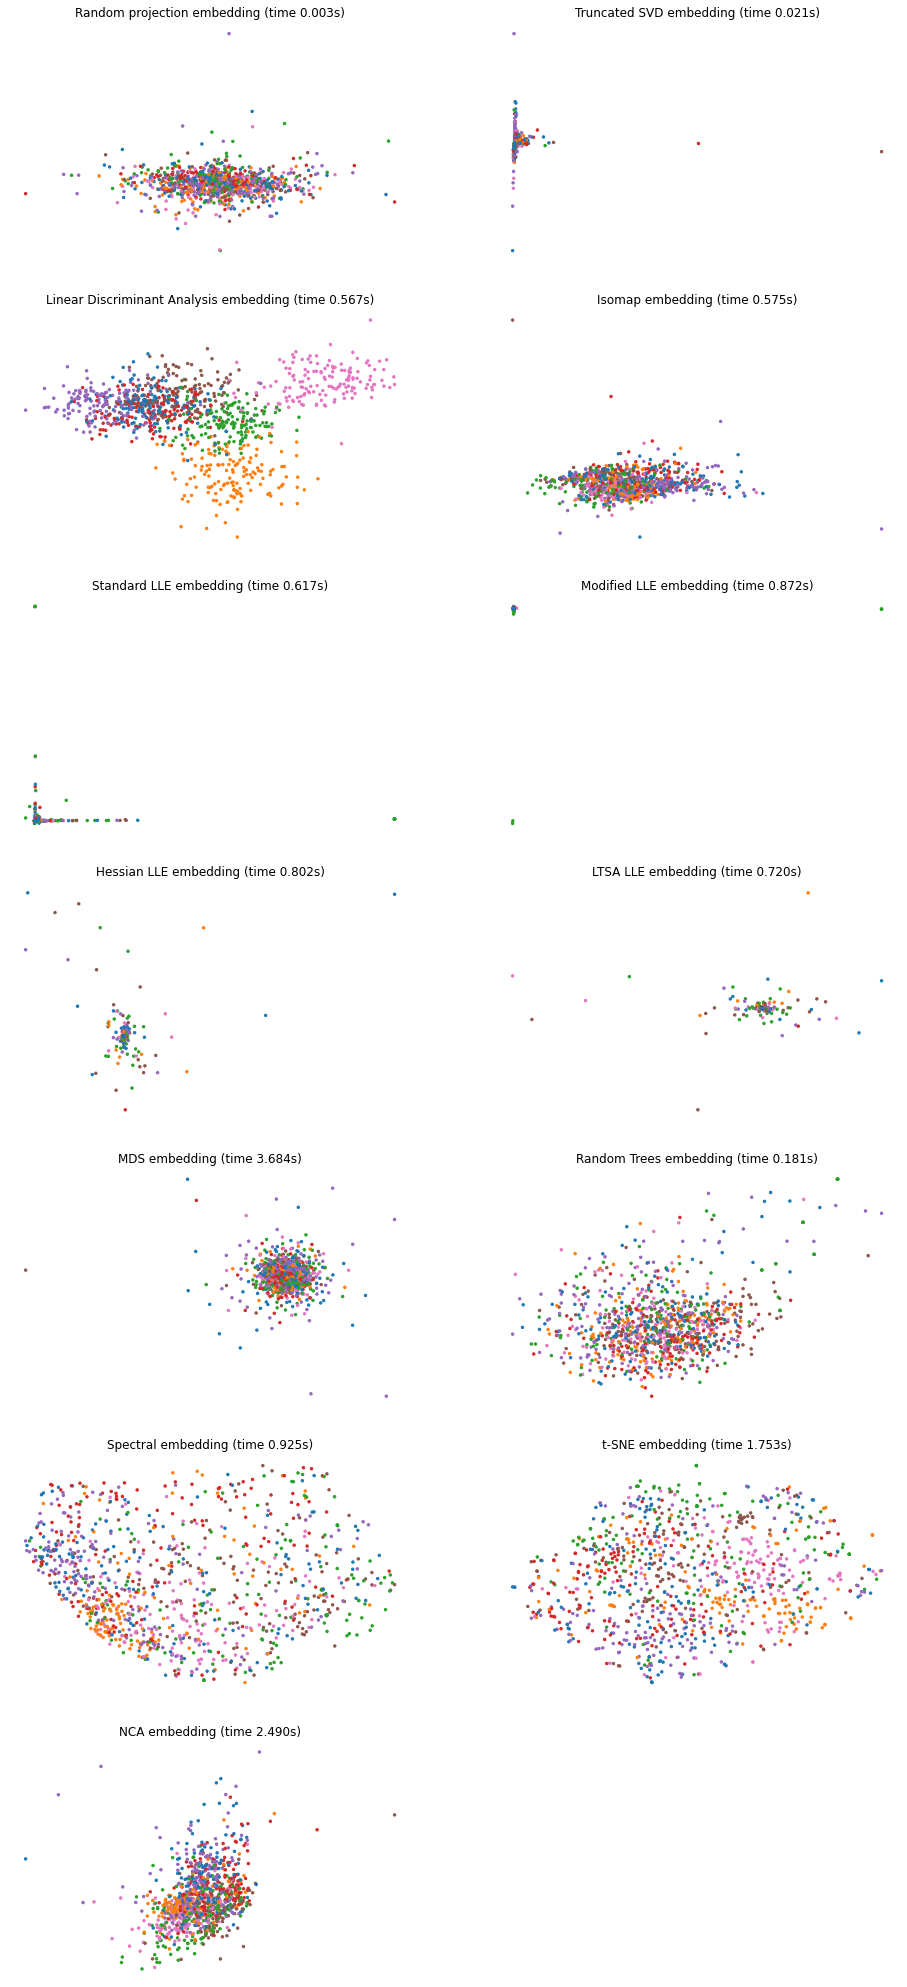

In [143]:
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(16, 36))

for name, ax in zip_longest(timing, axs.ravel()):
    if name is None:
        ax.axis("off")
        continue
    title = f"{name} (time {timing[name]:.3f}s)"
    plot_embedding(projections_embd[name], y, title, ax)

plt.show()

## 4.2 Version2 - 500 Features

In [34]:
data_ver = "Version2"
nfeatures = 500

In [35]:
# identification of key points and associated descriptors
temps1=time()

sift_keypoints_by_img = np.asarray(create_sift_keypoints(photo_list, PATH+"Flipkart\\Images\\", nfeatures=nfeatures))
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Number of SIFT descriptors : ", sift_keypoints_all.shape)

duration1=time()-temps1
print("Run time for the SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0000 Images have been treated.
0100 Images have been treated.
0200 Images have been treated.
0300 Images have been treated.
0400 Images have been treated.
0500 Images have been treated.
0600 Images have been treated.
0700 Images have been treated.
0800 Images have been treated.
0900 Images have been treated.
1000 Images have been treated.
1050 Images have been treated in total. --- END.


<ipython-input-35-1d5c103e69c5>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(create_sift_keypoints(photo_list, PATH+"Flipkart\\Images\\", nfeatures=nfeatures))



Number of SIFT descriptors :  (517351, 128)
Run time for the SIFT descriptor :           356.85 secondes


In [36]:
#from sklearn import cluster, metrics

# Determination number of clusters
temps1=time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Maximum Number of Clusters : ", k)
print(f"Creation of {k} SIFT-Descriptor Clusters ...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time()-temps1
print("Run time for MiniBatchKMeans : ", "%15.2f" % duration1, "seconds")

Maximum Number of Clusters :  719
Creation of 719 SIFT-Descriptor Clusters ...
Run time for MiniBatchKMeans :            10.25 seconds


In [37]:
# Creation of histograms (features)
temps1=time()

im_features = np.asarray(create_histogram_vectors(sift_keypoints_by_img, kmeans))

duration1=time()-temps1
print("Total time to create Histograms : ", "%15.2f" % duration1, "secondes")

0000 Images have been treated.
0100 Images have been treated.
0200 Images have been treated.
0300 Images have been treated.
0400 Images have been treated.
0500 Images have been treated.
0600 Images have been treated.
0700 Images have been treated.
0800 Images have been treated.
0900 Images have been treated.
1000 Images have been treated.
1050 Images have been treated in total. --- END.
Total time to create Histograms :            22.64 secondes


In [38]:
print("Dimensions of the dataset before reduction with a PCA : ", im_features.shape)
pca = PCA(n_components=0.99)
X_pca= pca.fit_transform(im_features)
print("Dimensions of the dataset after reduction with a PCA : ", X_pca.shape)

Dimensions of the dataset before reduction with a PCA :  (1050, 719)
Dimensions of the dataset after reduction with a PCA :  (1050, 498)


In [39]:
X_img_descriptors[data_ver] = sift_keypoints_by_img
X_img_featutres[data_ver] = im_features

In [40]:
X_datas[data_ver] = X_pca

### 4.2.1 Les Projections en 2D

In [41]:
data_ver = "Version2"
X_projections[data_ver] = {}

#### PCA

In [42]:
data_ver = "Version2"
proj_name = "PCA"
proj = PCA(n_components=2)

In [43]:
X_tmp = proj.fit_transform(X_datas[data_ver])
X_projections[data_ver][proj_name] = {"X_proj" : X_tmp}

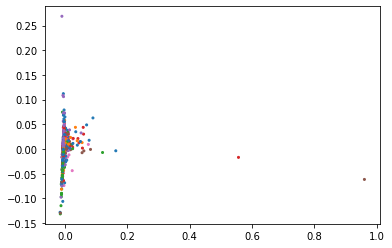

In [44]:
fig, ax = plt.subplots(figsize=(6,4))
X_tmp = X_projections[data_ver][proj_name]["X_proj"]
ax.scatter(X_tmp[:,0], X_tmp[:,1], c=y, 
           cmap=ListedColormap(sns.color_palette('tab10'), N=len(set(y))), s=4)
plt.show()

#### TSNE1

In [45]:
data_ver = "Version2"
proj_name = "TSNE1"
proj = TSNE(n_components=2, perplexity=10, n_iter=10000, init='pca', random_state=6)

In [46]:
X_tmp = proj.fit_transform(X_datas[data_ver])
X_projections[data_ver][proj_name] = {"X_proj" : X_tmp}

c:\users\bookj\environments\jupenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\users\bookj\environments\jupenv\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


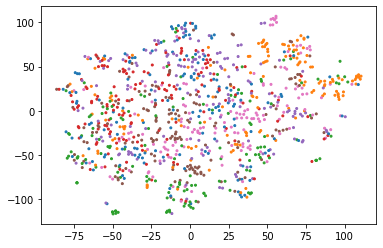

In [47]:
fig, ax = plt.subplots(figsize=(6,4))
X_tmp = X_projections[data_ver][proj_name]["X_proj"]
ax.scatter(X_tmp[:,0], X_tmp[:,1], c=y, 
           cmap=ListedColormap(sns.color_palette('tab10'), N=len(set(y))), s=4)
plt.show()

## 4.3 Version3 - 250 Features

In [48]:
data_ver = "Version3"
nfeatures = 250

In [49]:
# identification of key points and associated descriptors
temps1=time()

sift_keypoints_by_img = np.asarray(create_sift_keypoints(photo_list, PATH+"Flipkart\\Images\\", nfeatures=nfeatures))
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Number of SIFT descriptors : ", sift_keypoints_all.shape)

duration1=time()-temps1
print("Run time for the SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0000 Images have been treated.
0100 Images have been treated.
0200 Images have been treated.
0300 Images have been treated.
0400 Images have been treated.
0500 Images have been treated.
0600 Images have been treated.
0700 Images have been treated.
0800 Images have been treated.
0900 Images have been treated.
1000 Images have been treated.
1050 Images have been treated in total. --- END.


<ipython-input-49-1d5c103e69c5>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(create_sift_keypoints(photo_list, PATH+"Flipkart\\Images\\", nfeatures=nfeatures))



Number of SIFT descriptors :  (262397, 128)
Run time for the SIFT descriptor :           342.75 secondes


In [50]:
#from sklearn import cluster, metrics

# Determination number of clusters
temps1=time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Maximum Number of Clusters : ", k)
print(f"Creation of {k} SIFT-Descriptor Clusters ...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time()-temps1
print("Run time for MiniBatchKMeans : ", "%15.2f" % duration1, "seconds")

Maximum Number of Clusters :  512
Creation of 512 SIFT-Descriptor Clusters ...
Run time for MiniBatchKMeans :             5.56 seconds


In [51]:
# Creation of histograms (features)
temps1=time()

im_features = np.asarray(create_histogram_vectors(sift_keypoints_by_img, kmeans))

duration1=time()-temps1
print("Total time to create Histograms : ", "%15.2f" % duration1, "secondes")

0000 Images have been treated.
0100 Images have been treated.
0200 Images have been treated.
0300 Images have been treated.
0400 Images have been treated.
0500 Images have been treated.
0600 Images have been treated.
0700 Images have been treated.
0800 Images have been treated.
0900 Images have been treated.
1000 Images have been treated.
1050 Images have been treated in total. --- END.
Total time to create Histograms :            20.87 secondes


In [52]:
print("Dimensions of the dataset before reduction with a PCA : ", im_features.shape)
pca = PCA(n_components=0.99)
X_pca= pca.fit_transform(im_features)
print("Dimensions of the dataset after reduction with a PCA : ", X_pca.shape)

Dimensions of the dataset before reduction with a PCA :  (1050, 512)
Dimensions of the dataset after reduction with a PCA :  (1050, 403)


In [53]:
X_img_descriptors[data_ver] = sift_keypoints_by_img
X_img_featutres[data_ver] = im_features

In [54]:
X_datas[data_ver] = X_pca

### 4.3.1 Les Projections en 2D

In [55]:
data_ver = "Version3"
X_projections[data_ver] = {}

#### PCA

In [56]:
data_ver = "Version3"
proj_name = "PCA"
proj = PCA(n_components=2)

In [57]:
X_tmp = proj.fit_transform(X_datas[data_ver])
X_projections[data_ver][proj_name] = {"X_proj" : X_tmp}

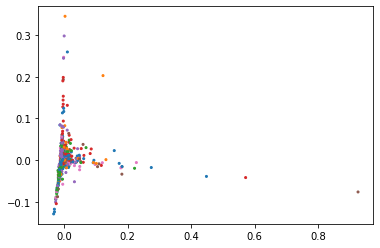

In [58]:
fig, ax = plt.subplots(figsize=(6,4))
X_tmp = X_projections[data_ver][proj_name]["X_proj"]
ax.scatter(X_tmp[:,0], X_tmp[:,1], c=y, 
           cmap=ListedColormap(sns.color_palette('tab10'), N=len(set(y))), s=4)
plt.show()

#### TSNE1

In [59]:
data_ver = "Version3"
proj_name = "TSNE1"
proj = TSNE(n_components=2, perplexity=9, learning_rate = 300, early_exaggeration=10, init='pca', 
            n_iter=2000, random_state=6)

In [60]:
X_tmp = proj.fit_transform(X_datas[data_ver])
X_projections[data_ver][proj_name] = {"X_proj" : X_tmp}

c:\users\bookj\environments\jupenv\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


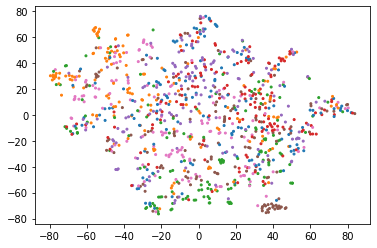

In [61]:
fig, ax = plt.subplots(figsize=(6,4))
X_tmp = X_projections[data_ver][proj_name]["X_proj"]
ax.scatter(X_tmp[:,0], X_tmp[:,1], c=y, 
           cmap=ListedColormap(sns.color_palette('tab10'), N=len(set(y))), s=4)
plt.show()

## 4.4 Version4 - 100 Features

In [62]:
data_ver = "Version4"
nfeatures = 100

In [63]:
# identification of key points and associated descriptors
temps1=time()

sift_keypoints_by_img = np.asarray(create_sift_keypoints(photo_list, PATH+"Flipkart\\Images\\", nfeatures=nfeatures))
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Number of SIFT descriptors : ", sift_keypoints_all.shape)

duration1=time()-temps1
print("Run time for the SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0000 Images have been treated.
0100 Images have been treated.
0200 Images have been treated.
0300 Images have been treated.
0400 Images have been treated.
0500 Images have been treated.
0600 Images have been treated.
0700 Images have been treated.
0800 Images have been treated.
0900 Images have been treated.
1000 Images have been treated.
1050 Images have been treated in total. --- END.

Number of SIFT descriptors :  (105381, 128)
Run time for the SIFT descriptor :           337.69 secondes


<ipython-input-63-1d5c103e69c5>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(create_sift_keypoints(photo_list, PATH+"Flipkart\\Images\\", nfeatures=nfeatures))


In [64]:
#from sklearn import cluster, metrics

# Determination number of clusters
temps1=time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Maximum Number of Clusters : ", k)
print(f"Creation of {k} SIFT-Descriptor Clusters ...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time()-temps1
print("Run time for MiniBatchKMeans : ", "%15.2f" % duration1, "seconds")

Maximum Number of Clusters :  325
Creation of 325 SIFT-Descriptor Clusters ...
Run time for MiniBatchKMeans :             2.09 seconds


In [65]:
# Creation of histograms (features)
temps1=time()

im_features = np.asarray(create_histogram_vectors(sift_keypoints_by_img, kmeans))

duration1=time()-temps1
print("Total time to create Histograms : ", "%15.2f" % duration1, "secondes")

0000 Images have been treated.
0100 Images have been treated.
0200 Images have been treated.
0300 Images have been treated.
0400 Images have been treated.
0500 Images have been treated.
0600 Images have been treated.
0700 Images have been treated.
0800 Images have been treated.
0900 Images have been treated.
1000 Images have been treated.
1050 Images have been treated in total. --- END.
Total time to create Histograms :            19.78 secondes


In [66]:
print("Dimensions of the dataset before reduction with a PCA : ", im_features.shape)
pca = PCA(n_components=0.99)
X_pca= pca.fit_transform(im_features)
print("Dimensions of the dataset after reduction with a PCA : ", X_pca.shape)

Dimensions of the dataset before reduction with a PCA :  (1050, 325)
Dimensions of the dataset after reduction with a PCA :  (1050, 283)


In [67]:
X_img_descriptors[data_ver] = sift_keypoints_by_img
X_img_featutres[data_ver] = im_features

In [68]:
X_datas[data_ver] = X_pca

### 4.4.1 Les Projections en 2D

In [69]:
data_ver = "Version4"
X_projections[data_ver] = {}

#### PCA

In [70]:
data_ver = "Version4"
proj_name = "PCA"
proj = PCA(n_components=2)

In [71]:
X_tmp = proj.fit_transform(X_datas[data_ver])
X_projections[data_ver][proj_name] = {"X_proj" : X_tmp}

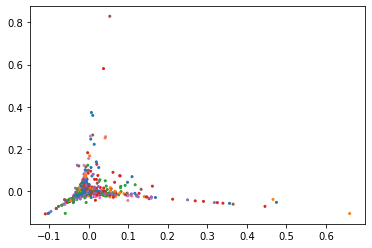

In [72]:
fig, ax = plt.subplots(figsize=(6,4))
X_tmp = X_projections[data_ver][proj_name]["X_proj"]
ax.scatter(X_tmp[:,0], X_tmp[:,1], c=y, 
           cmap=ListedColormap(sns.color_palette('tab10'), N=len(set(y))), s=4)
plt.show()

#### TSNE1

In [73]:
data_ver = "Version4"
proj_name = "TSNE1"
proj = TSNE(n_components=2, perplexity=8, learning_rate = 200, early_exaggeration=15, init='pca', 
            n_iter=2000, random_state=6)

In [74]:
X_tmp = proj.fit_transform(X_datas[data_ver])
X_projections[data_ver][proj_name] = {"X_proj" : X_tmp}

c:\users\bookj\environments\jupenv\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


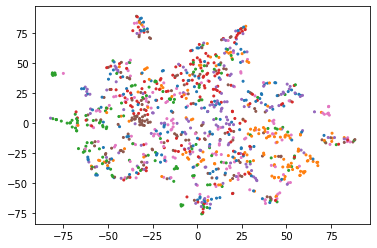

In [75]:
fig, ax = plt.subplots(figsize=(6,4))
X_tmp = X_projections[data_ver][proj_name]["X_proj"]
ax.scatter(X_tmp[:,0], X_tmp[:,1], c=y, 
           cmap=ListedColormap(sns.color_palette('tab10'), N=len(set(y))), s=4)
plt.show()

## 4.5 Version5 - Canny et 1000 Features

In [76]:
data_ver = "Version5"
nfeatures = 1000

In [77]:
# identification of key points and associated descriptors
temps1=time()

sift_keypoints_by_img = np.asarray(create_sift_keypoints(photo_list, PATH+"Flipkart\\Images\\", 
                                                         use_canny=True, nfeatures=nfeatures))
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Number of SIFT descriptors : ", sift_keypoints_all.shape)

duration1=time()-temps1
print("Run time for the SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0000 Images have been treated.
0100 Images have been treated.
0200 Images have been treated.
0300 Images have been treated.
0400 Images have been treated.
0500 Images have been treated.
0600 Images have been treated.
0700 Images have been treated.
0800 Images have been treated.
0900 Images have been treated.
1000 Images have been treated.
1050 Images have been treated in total. --- END.


<ipython-input-77-58b37b51e405>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(create_sift_keypoints(photo_list, PATH+"Flipkart\\Images\\",



Number of SIFT descriptors :  (951823, 128)
Run time for the SIFT descriptor :           353.15 secondes


In [78]:
#from sklearn import cluster, metrics

# Determination number of clusters
temps1=time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Maximum Number of Clusters : ", k)
print(f"Creation of {k} SIFT-Descriptor Clusters ...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time()-temps1
print("Run time for MiniBatchKMeans : ", "%15.2f" % duration1, "seconds")

Maximum Number of Clusters :  976
Creation of 976 SIFT-Descriptor Clusters ...
Run time for MiniBatchKMeans :            23.68 seconds


In [79]:
# Creation of histograms (features)
temps1=time()

im_features = np.asarray(create_histogram_vectors(sift_keypoints_by_img, kmeans))

duration1=time()-temps1
print("Total time to create Histograms : ", "%15.2f" % duration1, "secondes")

0000 Images have been treated.
0100 Images have been treated.
0200 Images have been treated.
0300 Images have been treated.
0400 Images have been treated.
0500 Images have been treated.
0600 Images have been treated.
0700 Images have been treated.
0800 Images have been treated.
0900 Images have been treated.
1000 Images have been treated.
1050 Images have been treated in total. --- END.
Total time to create Histograms :            24.37 secondes


In [80]:
print("Dimensions of the dataset before reduction with a PCA : ", im_features.shape)
pca = PCA(n_components=0.99)
X_pca= pca.fit_transform(im_features)
print("Dimensions of the dataset after reduction with a PCA : ", X_pca.shape)

Dimensions of the dataset before reduction with a PCA :  (1050, 976)
Dimensions of the dataset after reduction with a PCA :  (1050, 626)


In [81]:
X_img_descriptors[data_ver] = sift_keypoints_by_img
X_img_featutres[data_ver] = im_features

In [82]:
X_datas[data_ver] = X_pca

### 4.5.1 Les Projections en 2D

In [83]:
data_ver = "Version5"
X_projections[data_ver] = {}

#### PCA

In [84]:
data_ver = "Version5"
proj_name = "PCA"
proj = PCA(n_components=2)

In [85]:
X_tmp = proj.fit_transform(X_datas[data_ver])
X_projections[data_ver][proj_name] = {"X_proj" : X_tmp}

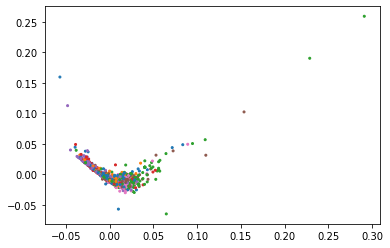

In [86]:
fig, ax = plt.subplots(figsize=(6,4))
X_tmp = X_projections[data_ver][proj_name]["X_proj"]
ax.scatter(X_tmp[:,0], X_tmp[:,1], c=y, 
           cmap=ListedColormap(sns.color_palette('tab10'), N=len(set(y))), s=4)
plt.show()

#### TSNE1

In [87]:
data_ver = "Version5"
proj_name = "TSNE1"
proj = TSNE(n_components=2, perplexity=8, n_iter=10000, learning_rate=2000, early_exaggeration=10, init='pca', random_state=6)

In [88]:
X_tmp = proj.fit_transform(X_datas[data_ver])
X_projections[data_ver][proj_name] = {"X_proj" : X_tmp}

c:\users\bookj\environments\jupenv\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


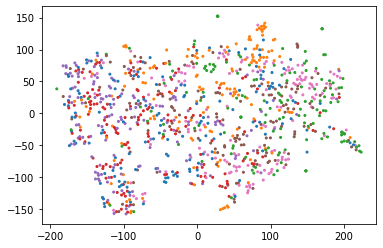

In [89]:
fig, ax = plt.subplots(figsize=(6,4))
X_tmp = X_projections[data_ver][proj_name]["X_proj"]
ax.scatter(X_tmp[:,0], X_tmp[:,1], c=y, 
           cmap=ListedColormap(sns.color_palette('tab10'), N=len(set(y))), s=4)
plt.show()

# 5. Clustering

## 5.1 KMeans

In [90]:
modelname = "KMeans"

for data_ver in ['Version1', 'Version2', 'Version3', 'Version4', 'Version5'] :
    scores = []
    for i in range(10):
            label = data_ver + '_' + modelname
            km = KMeans(n_clusters=7, n_init = 50, algorithm='full')
            X_labels[label] = km.fit_predict(X_datas[data_ver])
            scores.append(metrics.adjusted_rand_score(y, X_labels[label]))
        
    print(f"The rand score for the {data_ver} data is {round(np.array(scores).mean(),3)} " +
          f"+/- {round(np.array(scores).std(),3)}.")

The rand score for the Version1 data is 0.027 +/- 0.006.
The rand score for the Version2 data is 0.028 +/- 0.008.
The rand score for the Version3 data is 0.018 +/- 0.011.
The rand score for the Version4 data is 0.024 +/- 0.008.
The rand score for the Version5 data is 0.069 +/- 0.005.


#### TSNE1

In [159]:
data_ver = "Version1"
proj_name = "TSNE1"
modelname = "KMeans"
label = data_ver + '_' + modelname

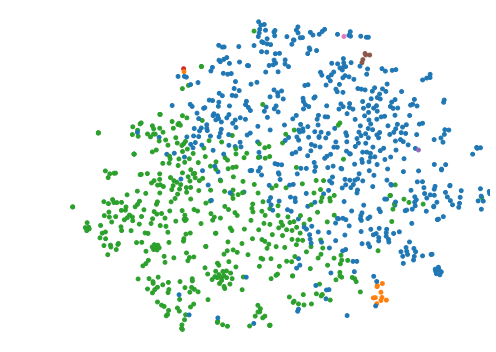

In [160]:
fig, ax = plt.subplots(figsize=(7,5))
X_tmp = X_projections[data_ver][proj_name]["X_proj"]
output = ax.scatter(X_tmp[:,0], X_tmp[:,1], c=X_labels[label], 
                    cmap=ListedColormap(sns.color_palette('tab10'), N=len(set(y))), s=15)
#legend1 = ax.legend(output.legend_elements()[0], le.inverse_transform([i for i in range(7)]),
#                    loc="upper left", frameon=False)
#ax.add_artist(legend1)
ax.axis('off')
plt.xlim(-80, 60)
#plt.ylim(-0.15, 0.15)
plt.tight_layout()

## 5.2 GaussianMixture

In [91]:
modelname = "GaussMixture"

for data_ver in ['Version1', 'Version2', 'Version3','Version4', 'Version5'] :
    scores = []
    for i in range(10):
            label = data_ver + '_' + modelname
            gm = GaussianMixture(n_components=7, n_init=10)
            X_labels[label] = gm.fit_predict(X_datas[data_ver])
            scores.append(metrics.adjusted_rand_score(y, X_labels[label]))
        
    print(f"The rand score for the {data_ver} data is {round(np.array(scores).mean(),3)} " +
          f"+/- {round(np.array(scores).std(),3)}.")

The rand score for the Version1 data is 0.038 +/- 0.008.
The rand score for the Version2 data is 0.034 +/- 0.003.
The rand score for the Version3 data is 0.036 +/- 0.006.
The rand score for the Version4 data is 0.026 +/- 0.004.
The rand score for the Version5 data is 0.057 +/- 0.005.


#### TSNE1

In [165]:
data_ver = "Version5"
proj_name = "TSNE1"
modelname = "GaussMixture"
label = data_ver + '_' + modelname

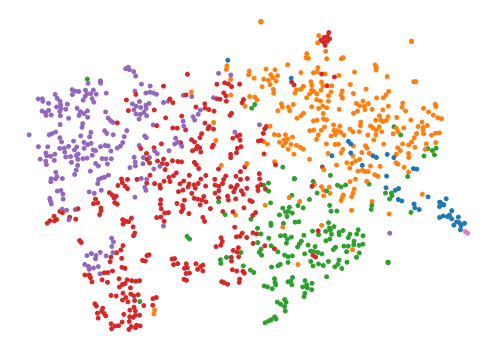

In [167]:
fig, ax = plt.subplots(figsize=(7,5))
X_tmp = X_projections[data_ver][proj_name]["X_proj"]
output = ax.scatter(X_tmp[:,0], X_tmp[:,1], c=X_labels[label], 
                    cmap=ListedColormap(sns.color_palette('tab10'), N=len(set(y))), s=15)
#legend1 = ax.legend(output.legend_elements()[0], le.inverse_transform([i for i in range(7)]),
#                    loc="upper left", frameon=False)
#ax.add_artist(legend1)
ax.axis('off')
#plt.xlim(-80, 60)
#plt.ylim(-0.15, 0.15)
plt.tight_layout()

## 5.3 AgglomerativeClustering

In [92]:
modelname = "AggClust"

for data_ver in ['Version1', 'Version2', 'Version3', 'Version4', 'Version5'] :
    label = data_ver + '_' + modelname
    ac = AgglomerativeClustering(n_clusters=7)
    X_labels[label] = ac.fit_predict(X_datas[data_ver])        
    print(f"The rand score for the {data_ver} data is {round(metrics.adjusted_rand_score(y, X_labels[label]),3)}.")

The rand score for the Version1 data is 0.0.
The rand score for the Version2 data is 0.002.
The rand score for the Version3 data is 0.003.
The rand score for the Version4 data is 0.025.
The rand score for the Version5 data is 0.059.


#### TSNE1

In [168]:
data_ver = "Version1"
proj_name = "TSNE1"
modelname = "AggClust"
label = data_ver + '_' + modelname

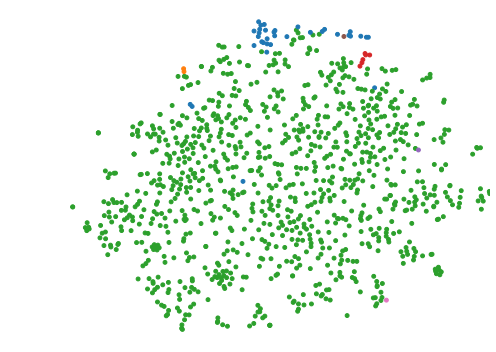

In [169]:
fig, ax = plt.subplots(figsize=(7,5))
X_tmp = X_projections[data_ver][proj_name]["X_proj"]
output = ax.scatter(X_tmp[:,0], X_tmp[:,1], c=X_labels[label], 
                    cmap=ListedColormap(sns.color_palette('tab10'), N=len(set(y))), s=15)
#legend1 = ax.legend(output.legend_elements()[0], le.inverse_transform([i for i in range(7)]),
#                    loc="upper left", frameon=False)
#ax.add_artist(legend1)
ax.axis('off')
plt.xlim(-80, 60)
#plt.ylim(-0.15, 0.15)
plt.tight_layout()

## 5.4 SpectralClustering

In [93]:
modelname = "SpecClust"

for data_ver in ['Version1', 'Version2', 'Version3', 'Version4', 'Version5'] :
    scores = []
    param_list = []
    for gamma in np.linspace(1, 9, 10):
        for affinity in ['sigmoid', 'rbf']:
            for coef0 in np.linspace(0.5, 2.5, 11):
                param_list.append((affinity, gamma, coef0))
                #print(f"fitting.... affinity:{affinity} | gamma:{gamma} | coef0:{coef0}")
                label = data_ver + '_' + modelname
                sp = SpectralClustering(n_clusters = 7, gamma=gamma, affinity=affinity, coef0 = coef0,
                                        assign_labels='discretize', random_state=33)
                X_labels[label] = sp.fit_predict(X_datas[data_ver])
                scores.append(metrics.adjusted_rand_score(y, X_labels[label]))
                if affinity == 'rbf' : break
    print(f"The best score for {data_ver} was {round(np.array(scores).max(),3)} with (affinity, gamma, coef0) = " +
          f"{param_list[scores.index(np.array(scores).max())]}.")

The best score for Version1 was 0.045 with (affinity, gamma, coef0) = ('sigmoid', 8.11111111111111, 1.5).
The best score for Version2 was 0.045 with (affinity, gamma, coef0) = ('sigmoid', 9.0, 2.1).
The best score for Version3 was 0.038 with (affinity, gamma, coef0) = ('sigmoid', 6.333333333333333, 0.9).
The best score for Version4 was 0.038 with (affinity, gamma, coef0) = ('sigmoid', 7.222222222222221, 0.9).
The best score for Version5 was 0.065 with (affinity, gamma, coef0) = ('sigmoid', 1.8888888888888888, 1.7000000000000002).


In [176]:
for data_ver, gamma, coef0 in zip(['Version'+str(i+1) for i in range(5)], [8.1,9,6.3,7.2,1.9], [1.5,2.1,0.9,0.9,1.7]) :
    label = data_ver + '_' + modelname
    sp = SpectralClustering(n_clusters = 7, gamma=gamma, affinity='sigmoid', coef0 = coef0,
                                        assign_labels='discretize', random_state=33)
    X_labels[label] = sp.fit_predict(X_datas[data_ver])

#### TSNE1

In [179]:
data_ver = "Version1"
proj_name = "TSNE1"
modelname = "SpecClust"
label = data_ver + '_' + modelname

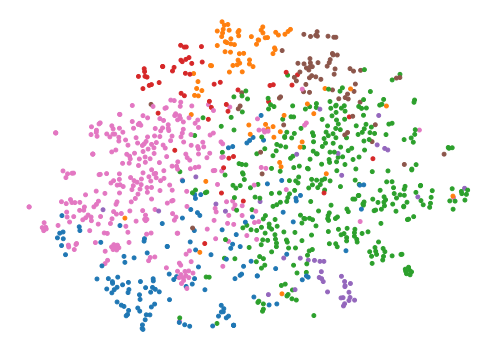

In [180]:
fig, ax = plt.subplots(figsize=(7,5))
X_tmp = X_projections[data_ver][proj_name]["X_proj"]
output = ax.scatter(X_tmp[:,0], X_tmp[:,1], c=X_labels[label], 
                    cmap=ListedColormap(sns.color_palette('tab10'), N=len(set(y))), s=15)
#legend1 = ax.legend(output.legend_elements()[0], le.inverse_transform([i for i in range(7)]),
#                    loc="upper left", frameon=False)
#ax.add_artist(legend1)
ax.axis('off')
#plt.xlim(-80, 60)
#plt.ylim(-0.15, 0.15)
plt.tight_layout()

# 6. Classification

In [94]:
seed = 33
testsize = 0.2
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = seed)

X_train, X_test, y_train, y_test = train_test_split(X_datas['Version1'], y, 
                                                    test_size=testsize, random_state=seed, shuffle=True, stratify=y)

## 6.1 KNeighborsClassifier

In [95]:
kn = KNeighborsClassifier()

In [96]:
kn.fit(X_train, y_train)
y_train_clf = kn.predict(X_train)
y_test_clf = kn.predict(X_test)
train_score = metrics.accuracy_score(y_train, y_train_clf)
test_score = metrics.accuracy_score(y_test, y_test_clf)
print(train_score, test_score)

0.594047619047619 0.43333333333333335


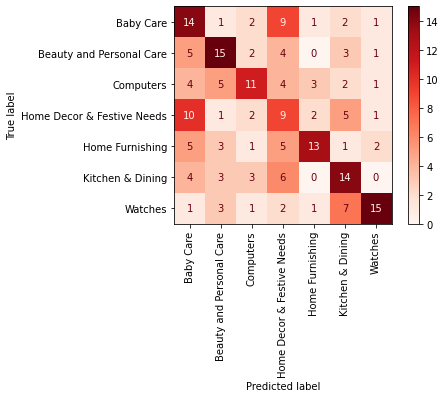

In [97]:
fig, ax = plt.subplots()
confmatrix = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_clf,
                                                             display_labels=[le.inverse_transform([i])[0] for i in range(7)],
                                                             xticks_rotation='vertical', cmap='Reds', ax=ax)

## 6.2 SVC

In [98]:
sv=SVC()

In [99]:
sv.fit(X_train, y_train)
y_train_clf = sv.predict(X_train)
y_test_clf = sv.predict(X_test)
train_score = metrics.accuracy_score(y_train, y_train_clf)
test_score = metrics.accuracy_score(y_test, y_test_clf)
print(train_score, test_score)

0.8107142857142857 0.5428571428571428


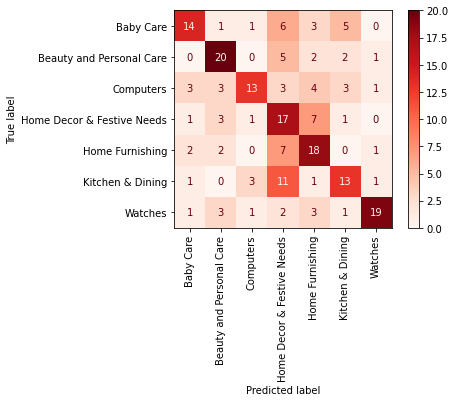

In [100]:
fig, ax = plt.subplots()
confmatrix = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_clf,
                                                             display_labels=[le.inverse_transform([i])[0] for i in range(7)],
                                                             xticks_rotation='vertical', cmap='Reds', ax=ax)

# 7. CNN

In [101]:
import tensorflow as tf

from tensorflow import keras
from keras.preprocessing.image import img_to_array, load_img, smart_resize

In [102]:
seed = 33
test_size = 0.2
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = seed)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(text_df['image_id'], y, 
                                                    test_size=test_size, random_state=seed, shuffle=True, stratify=y)

In [104]:
X_img_train = [img_to_array(load_img(PATH+"Flipkart\\Images\\"+name+'.jpg')) / 255 for name in X_train]
X_img_test = [img_to_array(load_img(PATH+"Flipkart\\Images\\"+name+'.jpg')) / 255 for name in X_test]

c:\users\bookj\environments\jupenv\lib\site-packages\PIL\Image.py:2911: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [105]:
print(np.array([img[:,:,0].shape[0] for img in X_img_train]).max(),
      np.array([img[:,:,0].shape[1] for img in X_img_train]).max())

11042 8484


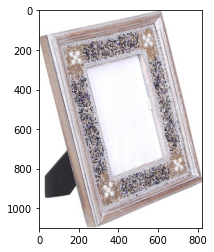

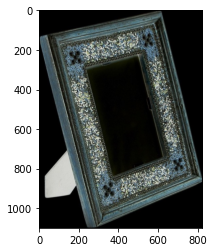

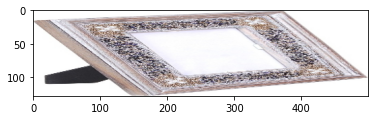

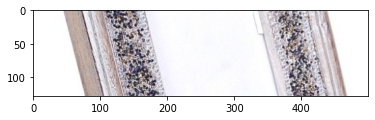

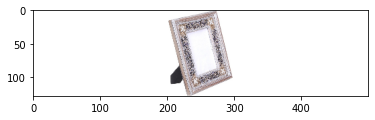

In [106]:
num=150
size = (128, 500)
plt.imshow(X_img_train[num])
plt.show()
plt.imshow(-1*(X_img_train[num])+1)
plt.show()
plt.imshow(tf.image.resize(X_img_train[num], size))
plt.show()
plt.imshow(smart_resize(X_img_train[num], size))
plt.show()
plt.imshow(-1*tf.image.resize_with_pad((-1*X_img_train[num])+1, size[0],size[1], method='bilinear' )+1)
plt.show()

In [107]:
def resize_with_white_pad(img, target_height, target_width, **kwargs):
    return -1*tf.image.resize_with_pad(-1*img+1, target_height, target_width, **kwargs)+1

In [108]:
target_size = (256, 256, 3)
target_height = target_size[0]
target_width = target_size[1]

In [109]:
X_img_train = np.array([resize_with_white_pad(img, target_height, target_width) for img in X_img_train])
X_img_test = np.array([resize_with_white_pad(img, target_height, target_width) for img in X_img_test])

In [110]:
input_shape=X_img_train.shape[1:]

In [182]:
y_train = np.argmax(y_train, axis=1)

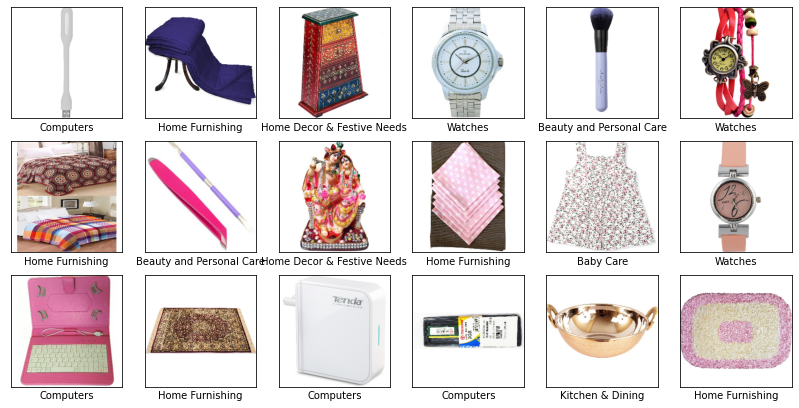

In [189]:
plt.figure(figsize=(14,7))
for i in range(18):
    plt.subplot(3,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_img_train[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(le.inverse_transform([y_train[i]])[0])
plt.show()

In [112]:
num_classes=len(set(y))
y_train = tf.one_hot(y_train, num_classes)
y_test = tf.one_hot(y_test, num_classes)

In [114]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.AveragePooling2D(pool_size=(4, 4)),
        keras.layers.Conv2D(8, kernel_size=(3, 3), activation="relu"),
        keras.layers.AveragePooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        #keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d (AverageP  (None, 64, 64, 3)        0         
 ooling2D)                                                       
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 8)         224       
                                                                 
 average_pooling2d_1 (Averag  (None, 31, 31, 8)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        4672      
                                                                 
 flatten (Flatten)           (None, 53824)             0         
                                                                 
 dropout (Dropout)           (None, 53824)             0

In [115]:
batch_size = 120 #120
epochs = 10

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(X_img_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_img_test, y_test))

Epoch 1/10
7/7 [==============================] - 3s 280ms/step - loss: 1.9714 - accuracy: 0.2298 - val_loss: 1.8756 - val_accuracy: 0.3476
Epoch 2/10
7/7 [==============================] - 1s 211ms/step - loss: 1.7283 - accuracy: 0.4643 - val_loss: 1.6723 - val_accuracy: 0.4143
Epoch 3/10
7/7 [==============================] - 2s 219ms/step - loss: 1.4678 - accuracy: 0.5429 - val_loss: 1.6275 - val_accuracy: 0.3905
Epoch 4/10
7/7 [==============================] - 1s 207ms/step - loss: 1.2824 - accuracy: 0.5762 - val_loss: 1.4663 - val_accuracy: 0.4571
Epoch 5/10
7/7 [==============================] - 1s 214ms/step - loss: 1.1288 - accuracy: 0.6405 - val_loss: 1.4603 - val_accuracy: 0.4381
Epoch 6/10
7/7 [==============================] - 1s 212ms/step - loss: 1.0661 - accuracy: 0.6655 - val_loss: 1.4567 - val_accuracy: 0.5048
Epoch 7/10
7/7 [==============================] - 1s 211ms/step - loss: 0.9254 - accuracy: 0.7060 - val_loss: 1.3371 - val_accuracy: 0.5381
Epoch 8/10
7/7 [====

In [116]:
y_test_clf = np.argmax(model.predict(X_img_test), axis=1)
y_test = np.argmax(y_test, axis=1)

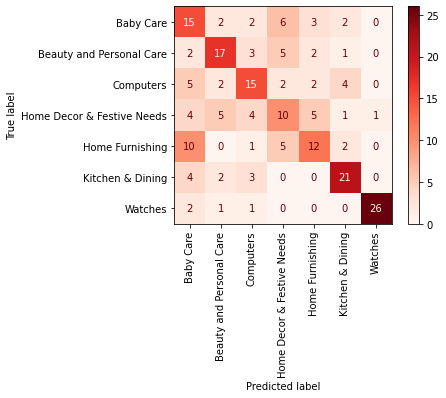

In [117]:
fig, ax = plt.subplots()
confmatrix = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_clf,
                                                             display_labels=[le.inverse_transform([i])[0] for i in range(7)],
                                                             xticks_rotation='vertical', cmap='Reds', ax=ax)